# Assignment 3

*Due on October 28th, 2020*

## Group Members

* Shai Slav
* Mark Forese


In [1]:
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt

### Problem One: Thermal Equilibrium in the Interstellar Medium (ISM)

#### Part A (1 point)
* I could give you a trial solution with which to start, but I won’t. That’d be too easy.
* “Ahhh,” you say, “but I can just plot (3) for a particular density to visually obtain my trial solution.” I’m not going to let you do that either. 
* Instead, I’d like you to write a program to figure out approximately where the root lies using the method of bracketing. 
* The idea is simple: 
<ol> <li> Choose two endpoints, T1 and T2 </li>
    <li> if L(n, T<sub>1</sub>) and L(n, T<sub>2</sub>) have opposite signs, then at least one root must lie in that interval </li>
</ol> 
* My advice is to start by setting n = 10−2, T1 = 6000, and T2 = 6001; it’s easy to check by substitution that L < 0 in this tiny range. Your program should increase T2 progressively
* Numerical Recipes iteratively adds 1.6(T2 − T1) to it—until it finds L(n, T<sub>1</sub>)L(n, T<sub>2</sub>) < 0. Record this T<sub>2</sub>; a root lies somewhere between it and T1.

In [79]:
gamma = 2E-26*u.erg / u.s

def lamb(T):
    try:
        T = T.value
    except AttributeError:
        pass
        
    lamb = gamma *(1e7*np.exp(-1.184e5 / (T + 1000)) + 1.4e-2*np.sqrt(T)*np.exp(-92/T))*u.cm**3
    return lamb

def L(n,T):
    return (n*lamb(T)).value - gamma.value

def find_bracket(n,T_1_start,T_2_start):
    L1 = L(n,T_1_start)
    L2 = L(n,T_2_start)
    
    T_1 = T_1_start
    T_2 = T_2_start
    counter = 0
    
    while(L1*L2 > 0 ):
        counter+=1
        T_2 += 1.6*(T_2-T_1)
        L2 = L(n,T_2)
        
    return [(T_1,T_2),counter]

In [80]:
n = 1E-2/u.cm**3
T_1_start = 6000*u.K
T_2_start = 6001*u.K

#print(L(n,T_1_start))
#print(L(n,T_2_start))

bracket = find_bracket(n,T_1_start,T_2_start)

In [81]:
print('The bracket is [{:.0f}, {:.0f}], which we found in {} iterations'.format(bracket[0][0],bracket[0][1],bracket[1]))

The bracket is [6000 K, 11430 K], which we found in 9 iterations


#### Part B (2 points)

* Using the bracketed interval you found in part (a), write a program to solve equation (3) for Teq when n = 10−2 using the bisection method. For your convergence criterion, accept a root as the “solution” once its value changes by < 10<sup>−10</sup> from one iteration to the next.

* In other words, T<sub>eq</sub> = T<sub>i</sub> if after iteration i you have $\epsilon_i ≡ \frac{|Ti − T_{i−1}|}{Ti} \leq 10^{-10}$.

* Record how many iterations it took for your initial “guess” at the bracket midpoint $T_0 = \frac{(T1 +T2)}{2}$ to converge to the “true” solution Teq; call it `Nbisiter`

* Compare `Nbisiter` to the expected value of $\log_2(\epsilon_0/\epsilon)$ steps to converge, where $\epsilon_0 ≡ \frac{|T2 − T1|}{T_{eq}}$ is the fractional size of the initial bracket

In [82]:
def epsilon(T_1,T_2):
    return np.abs(T_2 - T_1)/ T_2

def bracket_midpoint(T_1,T_2):
    return (T_1 + T_2)/2

T_1 = bracket[0][0]
T_2 = bracket[0][1]
eps_0 = epsilon(T_1,T_2)

eps = eps_0
tolerance = 1e-10

root = T_1

Nbisiter = 0

while(eps > 1e-10 and L(n,root)!=0):
    Nbisiter += 1
    #print(Nbisiter)
    #print(eps)
    midpoint = bracket_midpoint(T_1,T_2)
    L_mid = L(n,midpoint)
    
    if L_mid ==0:
        print('Found our root!')
        root = midpoint
        break
        
    elif L_mid*L(n,T_1) < 0:
        #print('Changing values between T_1 and Midpoint')
        T_2 = midpoint
        
    else:
        #print('Changing values between T_2 and Midpoint')
        T_1 = midpoint
    
    eps = epsilon(T_1,T_2)

root_1 = T_1

print('The root is {}, which we found in {itera} iterations.'.format(root,itera =Nbisiter))
#print(L(n,root))

The root is 6000.0 K, which we found in 33 iterations.


In [83]:
iter_expected = np.log2(eps_0/tolerance)
print('The expected number of iterations was %f' %iter_expected)

The expected number of iterations was 32.145410


**Our root was found in 33 iterations, which is very similar to the expected number of iterations needed, 32.145 (in fact they are identical when you take into account the fact that you can't have a fraction of an iteration)**

#### Part C (5 points)

Now that you have an accurate solution for Teq at n = 10<sup>−2</sup> , write a program to solve for T<sub>eq</sub> as a function of $n \in [10^{−2} , 10^3]$ using Newton-Raphson iteration with a tolerance of $\epsilon < 10^{−10}$ Note that you may use your converged answer $T_{eq}$ at $n = 10^{−2}$ as an initial guess for determining the equilibrium temperature at a slightly different density, say, $n = 10^{−1.96}$.

This procedure of using the previously converged $T_{eq}$ as an initial guess for $T_{eq}$ at the next n can be repeated to scan across the full range of n, provided that $T_{eq}$ does not change too rapidly from one n to the next. 

When you finish, make two log-log plots: one for $T_{eq}$ vs. n, and one for the equilibrium pressure p<sub>eq</sub> ≡ n x $T_{eq}$ vs. n. There’s something pretty neat in the latter plot that I discuss below. . . for now, just note that L > 0 (< 0) above (below) this curve

In [100]:
def grad_L(n,T):
    try:
        T = T.value
    except AttributeError:
        pass
    
    #calculated both of these terms by hand
    
    c = -1.184e5
    first_term = -c*1e7*np.exp(c/(T+1000))/(T+1000)**2
    
    second_term = 1.4e-2*(0.5/np.sqrt(T)*np.exp(-92/T)+ 92/T**1.5*np.exp(-92/T))
    
    dlamb = gamma.value*(first_term + second_term)
    
    return n*dlamb
'''
def hess_L(n,T):
    try:
        T = T.value
    except AttributeError:
        print('This temperature does not have units')
        pass
    
    #again, these second derivatives were calculated by hand and checked on a different piece of software
    c = -1.184e5
    first_term = 1e7*(2*c/(T+1000)**3 +c**2/(T+1000)**4)*np.exp(c/(T+1000))
    second_term = 46*np.exp(-92/T)/T**2.5 - np.exp(-92/T)/(4*T**1.5) - 138 / T**2.5
    
    dlamb = gamma.value*(first_term+second_term)
    
    return n*dlamb'''
    

def newton_raphson(guess_i,n,itrn_max = 1000,eps = 1e-10):
    xold = guess_i              # initial guess for NR iteration

    # begin NR iteration
    notdone = True
    itrtn = 0
    
    while (notdone and itrtn < itrn_max):
        f = L(n,xold)              # compute f at guess
        df = grad_L(n,xold)       # compute df/dx at guess
        if (df != 0):             # if df/dx != 0, proceed
            xnew = xold - f/df      # update guess using local slope
            error = abs(xnew-xold)  # compute change in answer
            if (error > eps*xnew):  # if change is more than tolerance
              xold = xnew           # set update as new guess for next iter
              itrtn += 1            # increment iteration counter
            else:
              root = xnew           # otherwise, accept as root
              notdone = False
            #print("At iteration %2d, the numerical root is %16.13f with \
                  #iteration error %.11e" % (itrtn, xnew, error/xnew ))
        else:
            print("derivative is zero!")
            break
        
    return root,itrtn

In [110]:
n_exp_min = -2
n_exp_max = 3

n_exponent_array = np.linspace(start = n_exp_min, stop = n_exp_max, num = 126) #exponents from -2, -1.96, ... 3
n_array = np.array([10**(exponent) for exponent in n_exponent_array])   #array of all the n values, no units
n_array

temp_solutions = np.zeros(len(n_array))
num_iterations = np.zeros(len(n_array))

temp_solutions[0] = root_1.value
num_iterations[0] = Nbisiter

for i in range(1,len(n_array)):
    n = n_array[i]
    root,num_iters = newton_raphson(temp_solutions[i-1],n)
    temp_solutions[i] = root
    num_iterations = num_iters
    
p_eq = n_array*temp_solutions

Text(0, 0.5, '$P_{eq} \\:[K \\; cm^{-3}]$ ')

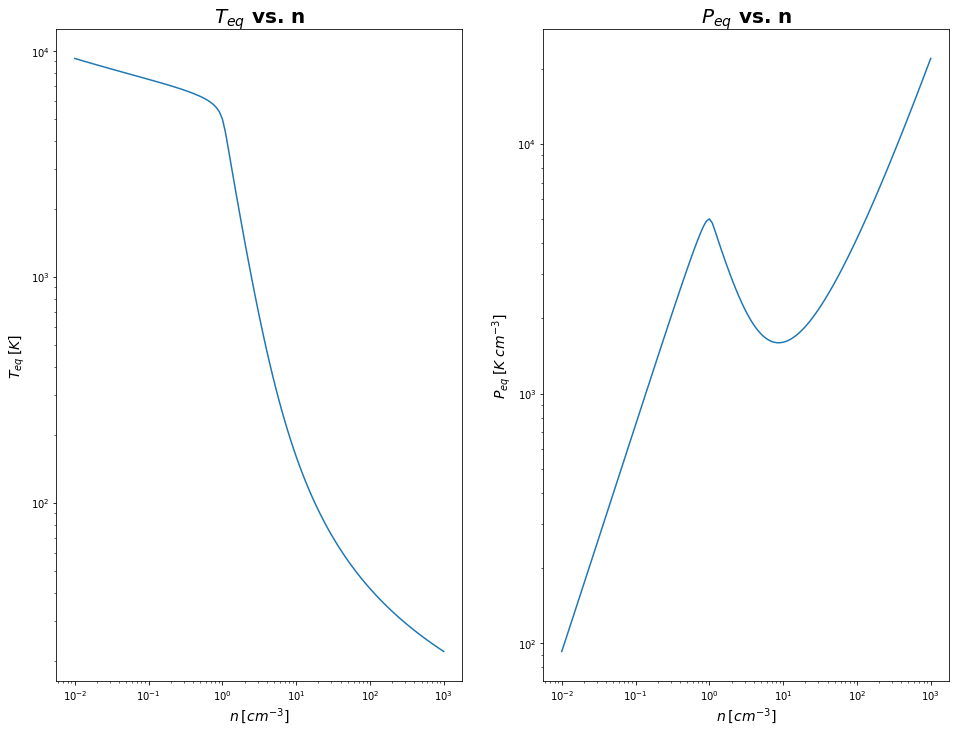

In [111]:
fig = plt.figure(figsize = (16,12))

ax_1 = plt.subplot(121)

ax_1.set_xscale('log',basex = 10)
ax_1.set_yscale('log',basey = 10)

ax_1.plot(n_array,temp_solutions)
ax_1.set_title(r'$T_{eq}$ vs. n',fontsize = 20,fontweight = 'bold')
ax_1.set_xlabel(r'$n \:[cm^{-3}]$',fontsize = 14,fontweight = 'bold')
ax_1.set_ylabel(r'$T_{eq} \:[K]$ ',fontsize = 14,fontweight = 'bold')

ax_2 = plt.subplot(122)

ax_2.set_xscale('log',basex = 10)
ax_2.set_yscale('log',basey = 10)

ax_2.plot(n_array,p_eq)
ax_2.set_title(r'$P_{eq}$ vs. n',fontsize = 20,fontweight = 'bold')
ax_2.set_xlabel(r'$n \:[cm^{-3}]$',fontsize = 14,fontweight = 'bold')
ax_2.set_ylabel(r'$P_{eq} \:[K \; cm^{-3}]$ ',fontsize = 14,fontweight = 'bold')